In [2]:
from utils.general_utils import *
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from utils.plot_utils import *
from explainerdashboard import ClassifierExplainer, ExplainerDashboard
from scipy.spatial.distance import cosine

First, we explore the given data, which of course consists of character basic info, stats and super-powers.

In [3]:
df = pd.read_csv('data/marvel_demo_stats_powers.csv').set_index("Name").drop(['ID', 'Unnamed: 0'], axis=1)
df.head()

,Alignment_x,Gender,EyeColor,Race,HairColor,Publisher,SkinColor,Height,Weight,Intelligence,...,Web Creation,Reality Warping,Odin Force,Symbiote Costume,Speed Force,Phoenix Force,Molecular Dissipation,Vision - Cryo,Omnipresent,Omniscient
Name,,,,,,,,,,,,,,,,,,,,,
A-Bomb,good,Male,yellow,Human,No Hair,Marvel Comics,-,203.0,441,38.0,...,False,False,False,False,False,False,False,False,False,False
Abomination,bad,Male,green,Human,No Hair,Marvel Comics,-,203.0,441,63.0,...,False,False,False,False,False,False,False,False,False,False
Abraxas,bad,Male,blue,Cosmic Entity,Black,Marvel Comics,-,-99.0,-99,88.0,...,False,False,False,False,False,False,False,False,False,False
Absorbing Man,bad,Male,blue,Human,No Hair,Marvel Comics,-,193.0,122,NaN,...,False,False,False,False,False,False,False,False,False,False
Agent 13,good,Female,blue,Unknown Race,Blond,Marvel Comics,-,173.0,61,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can easily see that our data consists of 3 main types of features:
      <br/> 1. Integers (the character's stats).
      <br/> 2. Booleans (The superpowers drilldown).
      <br/> 3. MultiCategorical features, which dictates the basic characteristics of each instance.
      <br/> Now, lets clean all of the unnecessary columns:

In [4]:
df = df.drop(['Publisher', 'SkinColor'], axis=1)
df.head()

,Alignment_x,Gender,EyeColor,Race,HairColor,Height,Weight,Intelligence,Strength,Speed,...,Web Creation,Reality Warping,Odin Force,Symbiote Costume,Speed Force,Phoenix Force,Molecular Dissipation,Vision - Cryo,Omnipresent,Omniscient
Name,,,,,,,,,,,,,,,,,,,,,
A-Bomb,good,Male,yellow,Human,No Hair,203.0,441,38.0,100.0,17.0,...,False,False,False,False,False,False,False,False,False,False
Abomination,bad,Male,green,Human,No Hair,203.0,441,63.0,80.0,53.0,...,False,False,False,False,False,False,False,False,False,False
Abraxas,bad,Male,blue,Cosmic Entity,Black,-99.0,-99,88.0,100.0,83.0,...,False,False,False,False,False,False,False,False,False,False
Absorbing Man,bad,Male,blue,Human,No Hair,193.0,122,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
Agent 13,good,Female,blue,Unknown Race,Blond,173.0,61,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


I removed the publisher feature since all of the data is from the same comicbook publisher (Marvel).
I removed SkinColor because this feature had way too much missing data to use here.

In [5]:
df = df.replace('-', 'no_value')
df['HairColor'].value_counts()

No Hair           94
Black             85
Blond             70
Brown             65
Red               25
White             16
Green              6
Grey               4
Blue               3
Purple             3
Orange             2
black              2
Silver             2
Pink               1
Magenta            1
Orange / White     1
Gold               1
Indigo             1
Name: HairColor, dtype: int64

We see that we have many sparse possible values in the HairColor category,
A possible solution to avoid that is to create a new value called 'other' and put
these values under that umbrella (exept 'black' who should be the same as 'Black').

In [6]:
haircolors_5_or_less = df['HairColor'].value_counts()
haircolors_5_or_less = haircolors_5_or_less.loc[haircolors_5_or_less < 5].index.tolist()
df['HairColor'] = df['HairColor'].apply(lambda x: "Black" if x == 'black' else 'Other' if x in haircolors_5_or_less else x)
df['HairColor'].value_counts()

No Hair    94
Black      87
Blond      70
Brown      65
Red        25
Other      19
White      16
Green       6
Name: HairColor, dtype: int64

Lets do the same with EyeColor:

In [7]:
df['EyeColor'].value_counts()

blue                       124
brown                       87
no_value                    47
green                       40
red                         31
white                       13
black                       11
yellow                      10
grey                         4
gold                         2
purple                       2
yellow (without irises)      2
hazel                        2
amber                        1
white / red                  1
silver                       1
green / blue                 1
blue / white                 1
violet                       1
yellow / blue                1
Name: EyeColor, dtype: int64

In [8]:
df['EyeColor'] = df['EyeColor'].apply(lambda x: 'green' if 'green' in x else 'blue' if 'blue' in x else 'yellow' if 'yellow' in x else 'white' if 'white' in x else x)

I've consolidated some of the EyeColor values (such as green + green/blue).
And now for the rest of the sparse values we can do exactly the same as we did with HairColor.

In [9]:
eyecolors_5_or_less = df['EyeColor'].value_counts()
eyecolors_5_or_less = eyecolors_5_or_less.loc[eyecolors_5_or_less < 5].index.tolist()
eyecolors_5_or_less.append('no_value')
df['EyeColor'] = df['EyeColor'].apply(lambda x: 'Other' if x in eyecolors_5_or_less else x)
df['EyeColor'].value_counts()

blue      126
brown      87
Other      60
green      41
red        31
white      14
yellow     12
black      11
Name: EyeColor, dtype: int64

Lets do this one last time for the 'Race' column.

In [10]:
race_3_or_less = df['Race'].value_counts()
print(race_3_or_less)
race_3_or_less = race_3_or_less.loc[race_3_or_less < 3].index.tolist()
print(race_3_or_less)
race_3_or_less.append('Unknown Race')
df['Race'] = df['Race'].apply(lambda x: 'Unknown Race' if x in race_3_or_less else x)
df['Race'].value_counts()

Unknown Race       144
Human              107
Mutant              58
Symbiote             9
Alien                7
Radiation            7
Asgardian            6
Cosmic Entity        6
Cyborg               5
God / Eternal        4
Inhuman              4
Demon                4
Android              2
Animal               2
Eternal              2
Frost Giant          2
Strontian            1
Flora Colossus       1
Zen-Whoberian        1
Demi-God             1
Vampire              1
Kree                 1
Spartoi              1
Atlantean            1
Luphomoid            1
Neyaphem             1
Clone                1
No Race              1
Kakarantharaian      1
Name: Race, dtype: int64
['Android', 'Animal', 'Eternal', 'Frost Giant', 'Strontian', 'Flora Colossus', 'Zen-Whoberian', 'Demi-God', 'Vampire', 'Kree', 'Spartoi', 'Atlantean', 'Luphomoid', 'Neyaphem', 'Clone', 'No Race', 'Kakarantharaian']


Unknown Race     165
Human            107
Mutant            58
Symbiote           9
Alien              7
Radiation          7
Cosmic Entity      6
Asgardian          6
Cyborg             5
God / Eternal      4
Inhuman            4
Demon              4
Name: Race, dtype: int64

"Now that we have our data clean, we can finally dictate the class out of the alignment column (is good or evil).
I've decided to label those who have no alignment value, or have a 'neutral' value, the same as bad value.

In [11]:
df['class'] = df['Alignment_x'].apply(lambda x: True if x in ['bad', 'neutral', '-'] else False)
df = df.drop('Alignment_x', axis=1)
df.head()

/var/folders/k5/1k0hk_9j2mvdfr7361v4cp4m0000gn/T/ipykernel_97102/2569021983.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


,Gender,EyeColor,Race,HairColor,Height,Weight,Intelligence,Strength,Speed,Durability,...,Reality Warping,Odin Force,Symbiote Costume,Speed Force,Phoenix Force,Molecular Dissipation,Vision - Cryo,Omnipresent,Omniscient,class
Name,,,,,,,,,,,,,,,,,,,,,
A-Bomb,Male,yellow,Human,No Hair,203.0,441,38.0,100.0,17.0,80.0,...,False,False,False,False,False,False,False,False,False,False
Abomination,Male,green,Human,No Hair,203.0,441,63.0,80.0,53.0,90.0,...,False,False,False,False,False,False,False,False,False,True
Abraxas,Male,blue,Cosmic Entity,Black,-99.0,-99,88.0,100.0,83.0,99.0,...,False,False,False,False,False,False,False,False,False,True
Absorbing Man,Male,blue,Human,No Hair,193.0,122,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,True
Agent 13,Female,blue,Unknown Race,Blond,173.0,61,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


From the context of the material we're working with, I can suggest that a big chunk of the good superheros tend to be human, mutant, or usually with blue eyes.
Because of that, I've decided to extract this information as unique boolean columns.


In [12]:
df['is_human'] = df['Race'].apply(lambda x: True if 'Human' in x else False)
df['is_mutant'] = df['Race'].apply(lambda x: True if 'Mutant' in x else False)
df['has_blue_eyes'] = df['EyeColor'].apply(lambda x: True if x == 'blue' else False)
df.head()


/var/folders/k5/1k0hk_9j2mvdfr7361v4cp4m0000gn/T/ipykernel_97102/3357497216.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
/var/folders/k5/1k0hk_9j2mvdfr7361v4cp4m0000gn/T/ipykernel_97102/3357497216.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
/var/folders/k5/1k0hk_9j2mvdfr7361v4cp4m0000gn/T/ipykernel_97102/3357497216.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(

,Gender,EyeColor,Race,HairColor,Height,Weight,Intelligence,Strength,Speed,Durability,...,Speed Force,Phoenix Force,Molecular Dissipation,Vision - Cryo,Omnipresent,Omniscient,class,is_human,is_mutant,has_blue_eyes
Name,,,,,,,,,,,,,,,,,,,,,
A-Bomb,Male,yellow,Human,No Hair,203.0,441,38.0,100.0,17.0,80.0,...,False,False,False,False,False,False,False,True,False,False
Abomination,Male,green,Human,No Hair,203.0,441,63.0,80.0,53.0,90.0,...,False,False,False,False,False,False,True,True,False,False
Abraxas,Male,blue,Cosmic Entity,Black,-99.0,-99,88.0,100.0,83.0,99.0,...,False,False,False,False,False,False,True,False,False,True
Absorbing Man,Male,blue,Human,No Hair,193.0,122,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,True,True,False,True
Agent 13,Female,blue,Unknown Race,Blond,173.0,61,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,True


For next references in the code, lets extract (and separate by type) all of the columns

In [13]:
cols = list(df.columns)
cat_cols = ['Gender', 'EyeColor', 'Race', 'HairColor']
int_cols = ['Height', 'Weight', 'Intelligence', 'Strength', 'Speed', 'Durability', 'Power', 'Combat', 'Total']
bool_cols = [x for x in cols if (x not in cat_cols and x not in int_cols)]

Also, lets quickly fill/fix the empty values in each column.

In [14]:
df[cat_cols] = df[cat_cols].fillna(value='no_value')
df[int_cols] = df[int_cols].fillna(value=0)
df[bool_cols] = df[bool_cols].fillna(value=False)
df.head()

,Gender,EyeColor,Race,HairColor,Height,Weight,Intelligence,Strength,Speed,Durability,...,Speed Force,Phoenix Force,Molecular Dissipation,Vision - Cryo,Omnipresent,Omniscient,class,is_human,is_mutant,has_blue_eyes
Name,,,,,,,,,,,,,,,,,,,,,
A-Bomb,Male,yellow,Human,No Hair,203.0,441,38.0,100.0,17.0,80.0,...,False,False,False,False,False,False,False,True,False,False
Abomination,Male,green,Human,No Hair,203.0,441,63.0,80.0,53.0,90.0,...,False,False,False,False,False,False,True,True,False,False
Abraxas,Male,blue,Cosmic Entity,Black,-99.0,-99,88.0,100.0,83.0,99.0,...,False,False,False,False,False,False,True,False,False,True
Absorbing Man,Male,blue,Human,No Hair,193.0,122,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,True,True,False,True
Agent 13,Female,blue,Unknown Race,Blond,173.0,61,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True


The last feature we'll add before injecting the data into a categories-considering model, is the amount of different superpowers for each character.

In [15]:
superpowers_cols = bool_cols
for col in ['is_human', 'is_mutant', 'has_blue_eyes', 'class']:
        if col in superpowers_cols:
                superpowers_cols.remove(col)

df['amount_of_superpowers'] = df[bool_cols].astype(int).sum(axis=1)
df['amount_of_superpowers_per_strength'] = df['amount_of_superpowers'] / (df['Strength'] + 1)
df['amount_of_superpowers_per_power'] = df['amount_of_superpowers'] / (df['Power'] + 1)
df['bmi'] = abs(df['Weight']) / (abs(df['Height'])/100)**2.
df.head()

,Gender,EyeColor,Race,HairColor,Height,Weight,Intelligence,Strength,Speed,Durability,...,Omnipresent,Omniscient,class,is_human,is_mutant,has_blue_eyes,amount_of_superpowers,amount_of_superpowers_per_strength,amount_of_superpowers_per_power,bmi
Name,,,,,,,,,,,,,,,,,,,,,
A-Bomb,Male,yellow,Human,No Hair,203.0,441,38.0,100.0,17.0,80.0,...,False,False,False,True,False,False,7,0.069307,0.388889,107.015458
Abomination,Male,green,Human,No Hair,203.0,441,63.0,80.0,53.0,90.0,...,False,False,True,True,False,False,8,0.098765,0.142857,107.015458
Abraxas,Male,blue,Cosmic Entity,Black,-99.0,-99,88.0,100.0,83.0,99.0,...,False,False,True,False,False,True,14,0.138614,0.138614,101.010101
Absorbing Man,Male,blue,Human,No Hair,193.0,122,0.0,0.0,0.0,0.0,...,False,False,True,True,False,True,11,11.000000,11.000000,32.752557
Agent 13,Female,blue,Unknown Race,Blond,173.0,61,0.0,0.0,0.0,0.0,...,False,False,False,False,False,True,0,0.000000,0.000000,20.381570


cast int cols to int type.

In [16]:
for col in int_cols:
    df[col] = df[col].astype(int)


Our data is ready for the model, we can now seperate it to X and Y.

In [17]:
df = df.reset_index()
X, y = df.copy().drop('class', axis=1), df.copy()['class']

In [25]:
# Model init
cbc = CatBoostClassifier(cat_features=get_cat_feature_names(X), class_weights=[0.3, 0.7], random_state=5,
                         bootstrap_type='Bayesian', rsm=0.1, verbose=0)
evaluation = Evaluation()

Notice the following:
 1. we're using a simple homemade function to extract the categorical features, but we could've used the list we prepared earlier.
 2. The class weights are in inverse proportion to the class values, as it should.
 3. I've chosen the other hyperparameters after testing several for this model.
Lets use the following homemade method to fit and also use stratified k-fold to see the performance:

In [26]:
list(get_cat_feature_names(X))

['Name', 'Gender', 'EyeColor', 'Race', 'HairColor']

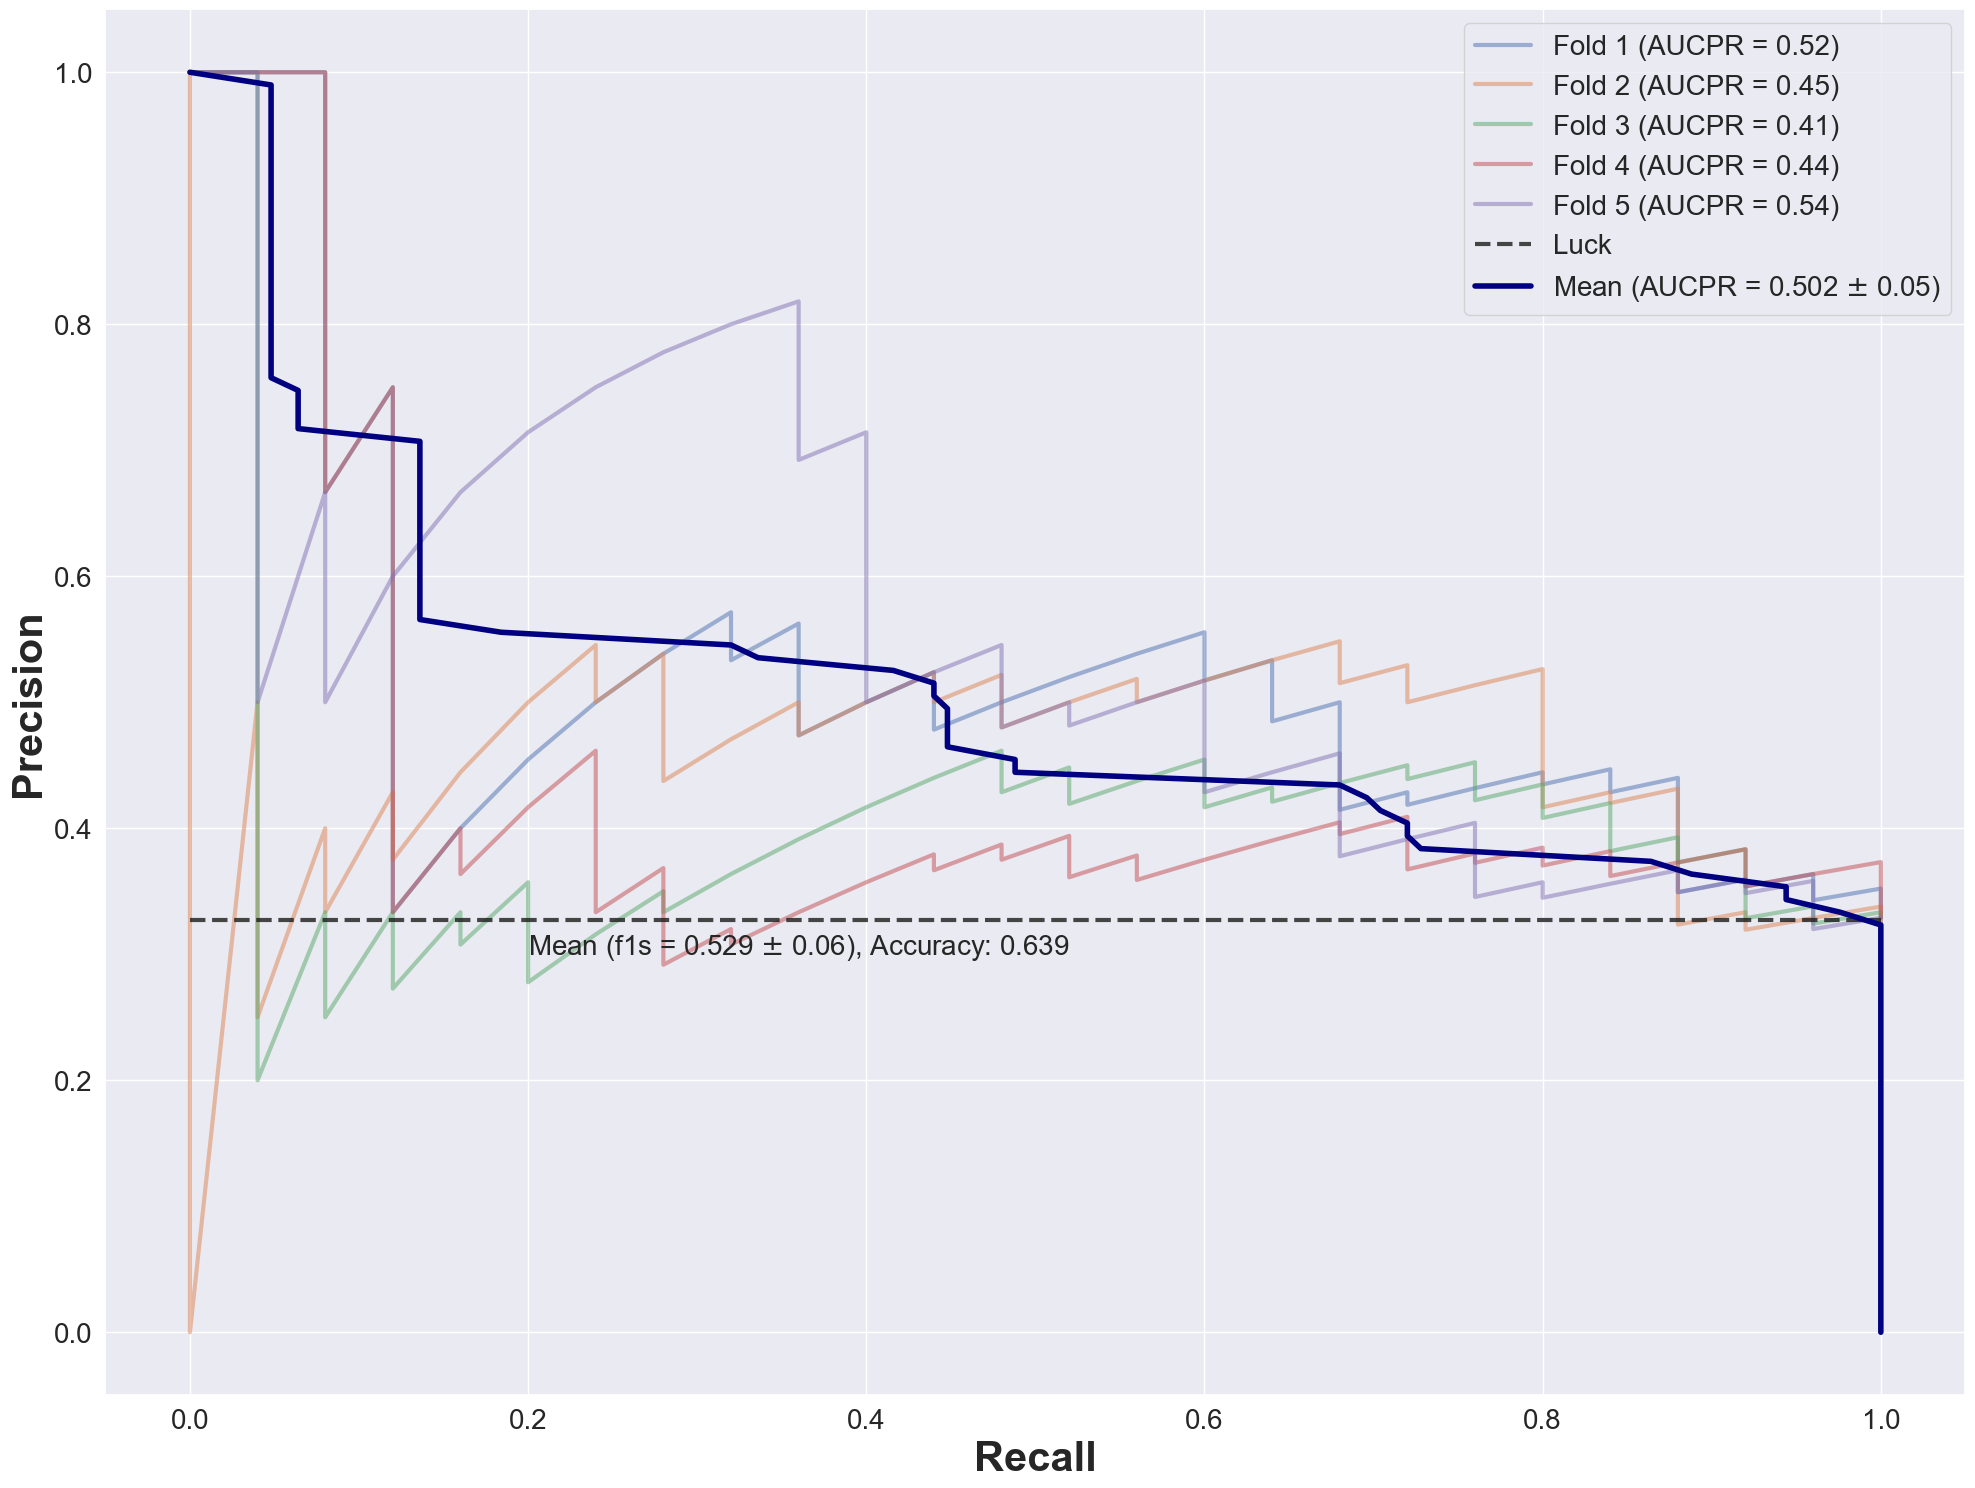

In [27]:
feature_importance = evaluation.plot_cv_precision_recall(cbc, n_folds=5, n_repeats=1, X=X, y=y, random_state=0)

Interesting results, this is a definite improvement over a 'lucky' guess.
Lets check the feature importance as well:

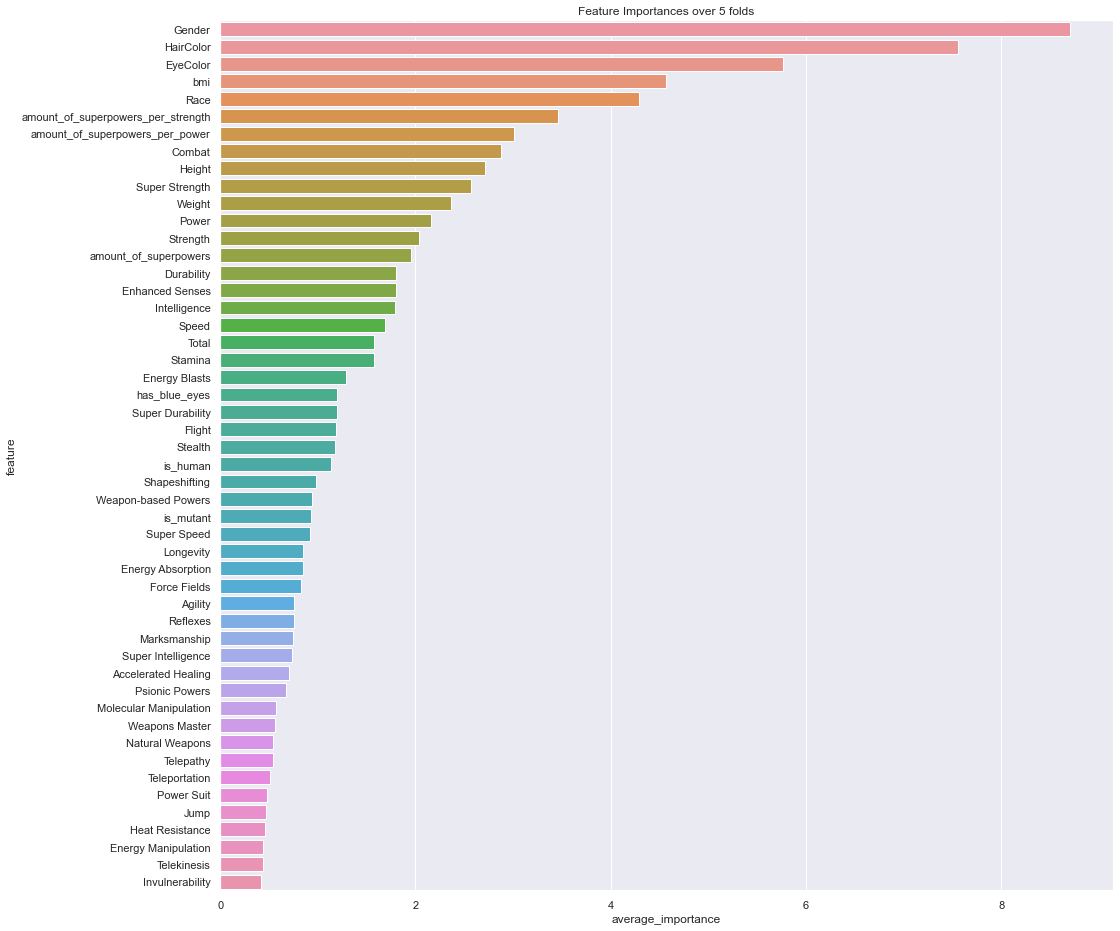

In [19]:
evaluation.plot_feature_importance(feature_importance, n_features_to_show=50)

Cool to see our engineered feature 'amount_of_superpowers' is at the top.
<br/> Also, interestingly enough, all of our categorical features are at the top as well.
<br/> Since we know our end goal is to create a character creator, I'd prefer to get rid of all features that don't help the model too much if any at all.
<br/> The main reason for that is to make the layout of the UI + the process itself as clean and simple as possible, without harming the performance.

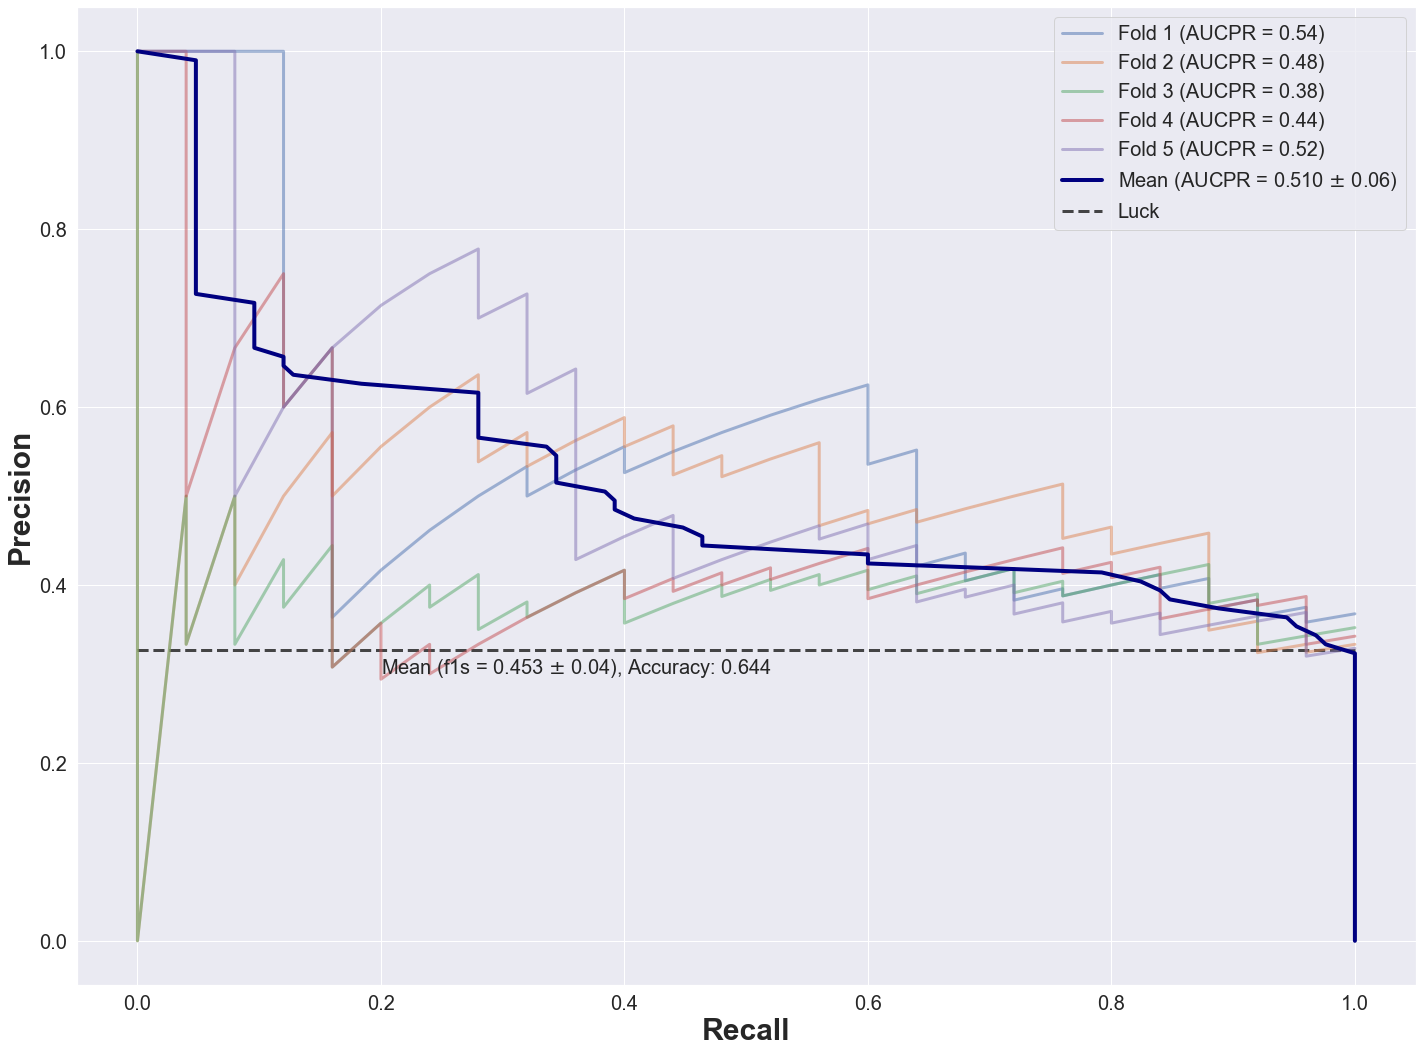

In [20]:
top_features_and_class = [
        # categorical features
        'Gender',
        'HairColor',
        'EyeColor',
        'Race',
        # int features
        'Strength',
        'Speed',
        'Durability',
        'Power',
        'Combat',
        'Intelligence',
        'Height',
        'Weight',
        'Total',
        'amount_of_superpowers',
        'amount_of_superpowers_per_strength',
        'amount_of_superpowers_per_power',
        'bmi',
        # Boolean features
        'Super Strength',
        'Stamina',
        'Stealth',
        'Enhanced Senses',
        'Flight',
        'Energy Blasts',
        'Energy Absorption',
        'Shapeshifting',
        'Accelerated Healing',
        'Force Fields',
        'Psionic Powers',
        'Weapon-based Powers',
        'Energy Manipulation',
        'Reflexes',
        'Molecular Manipulation',
        'Super Durability',
        'Agility',
        'Longevity',
        'Super Speed',
        'is_human',
        'is_mutant',
        'has_blue_eyes',
        'class']
df = df[top_features_and_class]
X, y = df.drop('class', axis=1), df['class']
cbc = CatBoostClassifier(cat_features=get_cat_feature_names(X), class_weights=[0.33, 0.67], random_state=5,
                         bootstrap_type='Bayesian', rsm=0.1, verbose=0)
feature_importance = evaluation.plot_cv_precision_recall(cbc, n_folds=5, n_repeats=1, X=X, y=y, random_state=0)

We even achieved somewhat higher accuracy. now lets explore the feature importance now:

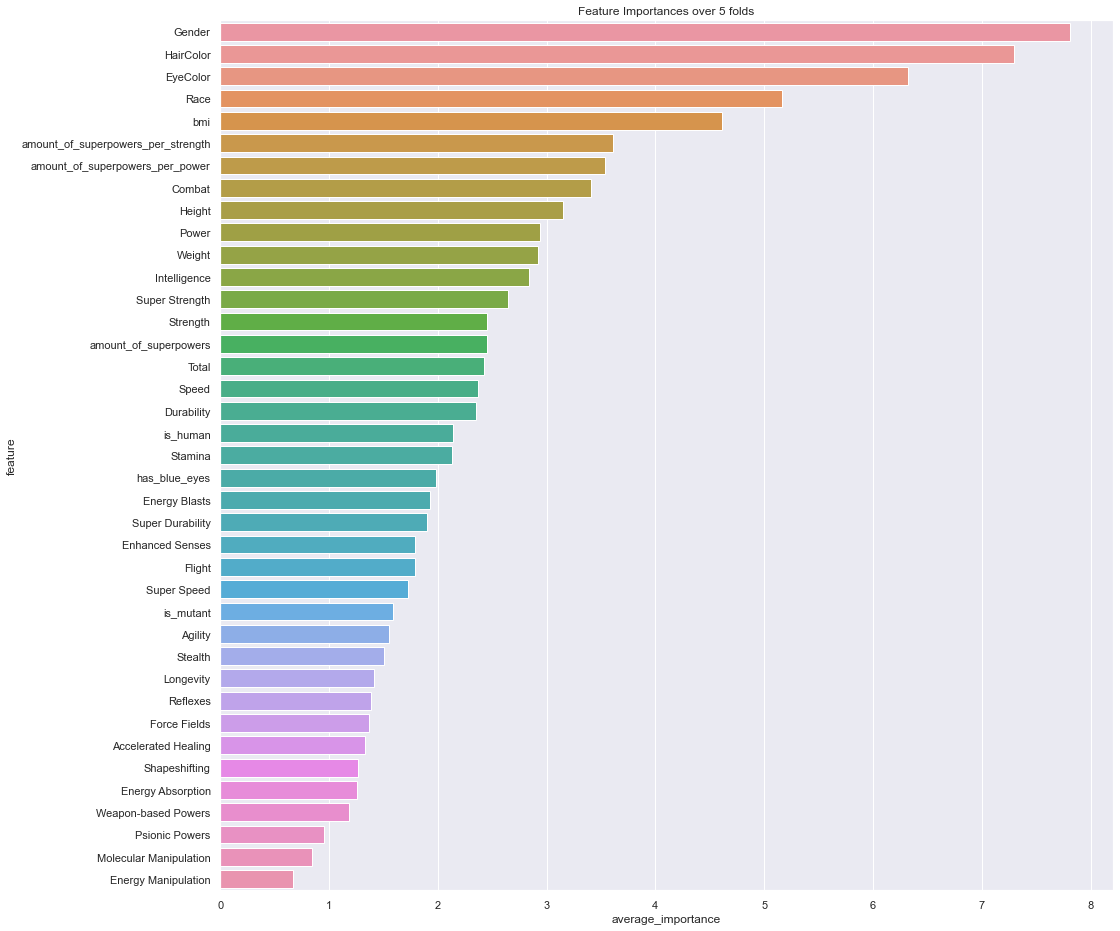

In [21]:
evaluation.plot_feature_importance(feature_importance, n_features_to_show=50)

In [22]:
X.head()

,Gender,HairColor,EyeColor,Race,Strength,Speed,Durability,Power,Combat,Intelligence,...,Energy Manipulation,Reflexes,Molecular Manipulation,Super Durability,Agility,Longevity,Super Speed,is_human,is_mutant,has_blue_eyes
0,Male,No Hair,yellow,Human,100,17,80,17,64,38,...,False,False,False,True,False,True,False,True,False,False
1,Male,No Hair,green,Human,80,53,90,55,95,63,...,False,False,False,False,False,False,True,True,False,False
2,Male,Black,blue,Cosmic Entity,100,83,99,100,56,88,...,True,False,True,False,False,False,True,False,False,True
3,Male,No Hair,blue,Human,0,0,0,0,0,0,...,False,False,True,True,False,False,False,True,False,True
4,Female,Blond,blue,Unknown Race,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,True


For further performance exploring and feature engineering, I've used the following helpful explainerdashboard package:

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
cbc.fit(X_train, y_train)
explainer = ClassifierExplainer(cbc, X_test, y_test)
ExplainerDashboard(explainer, simple=True).run()


Generating self.shap_explainer = shap.TreeExplainer(model)
Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
Calculating shap values...
Generating layout...
Calculating dependencies...
Calculating confusion matrices...
Calculating prediction probabilities...
Calculating metrics...
Calculating predictions...
Calculating pred_percentiles...
Calculating roc auc curves...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Starting ExplainerDashboard on http://100.64.0.1:8050
Dash is running on http://0.0.0.0:8050/

 * Serving Flask app 'explainerdashboard.dashboards' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


OSError: [Errno 48] Address already in use

In [ ]:
df_for_similarity = df.copy()
df_for_similarity

In [ ]:
for col in df_for_similarity.columns:
        if df_for_similarity[col].dtypes == bool:
                df_for_similarity[col] = df_for_similarity[col].astype(int)

df_for_similarity['Gender'] = df_for_similarity['Gender'].apply(lambda x: 1 if x == 'Male' else 0)
df_for_similarity

In [ ]:
cat_cols = ['Race', 'EyeColor', 'HairColor']
for col in cat_cols:
        col_values = list(df_for_similarity[col].value_counts().index.to_list())
        for value in col_values:
                new_col_name = str(col) + "_" + str(value)
                df_for_similarity[new_col_name] = df_for_similarity[col].apply(lambda x: 1 if x == value else 0)

df_for_similarity = df_for_similarity.drop(cat_cols, axis=1)
df_for_similarity

In [ ]:
scaler = StandardScaler()
df_for_similarity_scaled = pd.DataFrame(scaler.fit_transform(df_for_similarity), columns=df_for_similarity.columns)
df_for_similarity_scaled

In [ ]:
X_sample = df_for_similarity.loc[5:6, :]
X_sample

In [ ]:
X_sample = scaler.transform(X_sample)
X_sample = X_sample[0]

In [ ]:
dists = [cosine(X_sample, df_for_similarity_scaled.loc[i]) for i in range(df_for_similarity.shape[0])]
original_df = pd.read_csv('data/marvel_demo_stats_powers.csv')
closet_obs = original_df.loc[np.argmin(dists)]
closet_obs['Name']